In [3]:
# https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5#scrollTo=0e4vdDIOXyxF

In [4]:
%matplotlib inline
from pycocotools.coco import COCO
#import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
#import pylab
#import random
#pylab.rcParams['figure.figsize'] = (8.0, 10.0)# Import Libraries

import datetime
# For visualization
import os
#import seaborn as sns
from matplotlib import colors
from tensorboard.backend.event_processing import event_accumulator as ea
#from PIL import Image


%matplotlib inline

#### Load data (COCO data)

In [5]:
# initialize data paths
dataset_dir = "data/coco/"
img_dir = "img/"
train_dir = "train/"
val_dir = "val/"
test_dir = "test/"
test_dir = os.path.join(dataset_dir, test_dir)

img_dir = os.path.join(dataset_dir,img_dir)

# single class annotations: damage
ann_file_train = os.path.join(dataset_dir,train_dir,"COCO_train_annos.json")
ann_file_val = os.path.join(dataset_dir,val_dir,"COCO_val_annos.json")

# multi class annotations: headlamp, rear_bumper, door, hood, front_bumper
ann_file_mul_val = os.path.join(dataset_dir,val_dir,"COCO_mul_val_annos.json")
ann_file_mul_train = os.path.join(dataset_dir,train_dir,"COCO_mul_train_annos.json")

In [6]:
# initialize coco api for instance annotations
coco=COCO(ann_file_val)
mul_coco=COCO(ann_file_mul_val)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [7]:
# display categories and supercategories

#Single Class #Damage dataset
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories for damages: \n{}\n'.format(', '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories for damages: \n{}\n'.format(', '.join(nms)))

#Multi Class #Parts dataset

mul_cats = mul_coco.loadCats(mul_coco.getCatIds())
mul_nms=[cat['name'] for cat in mul_cats]
print('COCO categories for parts: \n{}\n'.format(', '.join(mul_nms)))

mul_nms = set([mul_cat['supercategory'] for mul_cat in mul_cats])
print('COCO supercategories for parts: \n{}\n'.format(', '.join(mul_nms)))

COCO categories for damages: 
damage

COCO supercategories for damages: 
part

COCO categories for parts: 
headlamp, rear_bumper, door, hood, front_bumper

COCO supercategories for parts: 
part



# Model

In [8]:
# install detectron2
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

ERROR: Invalid requirement: "'git+https://github.com/facebookresearch/detectron2.git'"


In [9]:
#!python -m pip install opencv-python
#!python -m pip install torch torchvision torchaudio

In [10]:
import detectron2
from detectron2.utils.logger import setup_logger

import torch, torchvision
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print(torch.__version__, torch.cuda.is_available())
print("detectron2:", detectron2.__version__)


1.13.1+cpu False
detectron2: 0.6


'nvcc' is not recognized as an internal or external command,
operable program or batch file.


In [11]:
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
import skimage.io as io

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Set base params
plt.rcParams["figure.figsize"] = [16,9]

In [39]:
ann_file_train

'data/coco/train/COCO_train_annos.json'

In [12]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("car_dataset_train", {}, ann_file_train, img_dir)
register_coco_instances("car_dataset_val", {}, ann_file_val, img_dir)

In [13]:
dataset_dicts = DatasetCatalog.get("car_dataset_train")
metadata_dicts = MetadataCatalog.get("car_dataset_train")

[03/01 14:48:07 d2.data.datasets.coco]: Loaded 59 images in COCO format from data/coco/train/COCO_train_annos.json


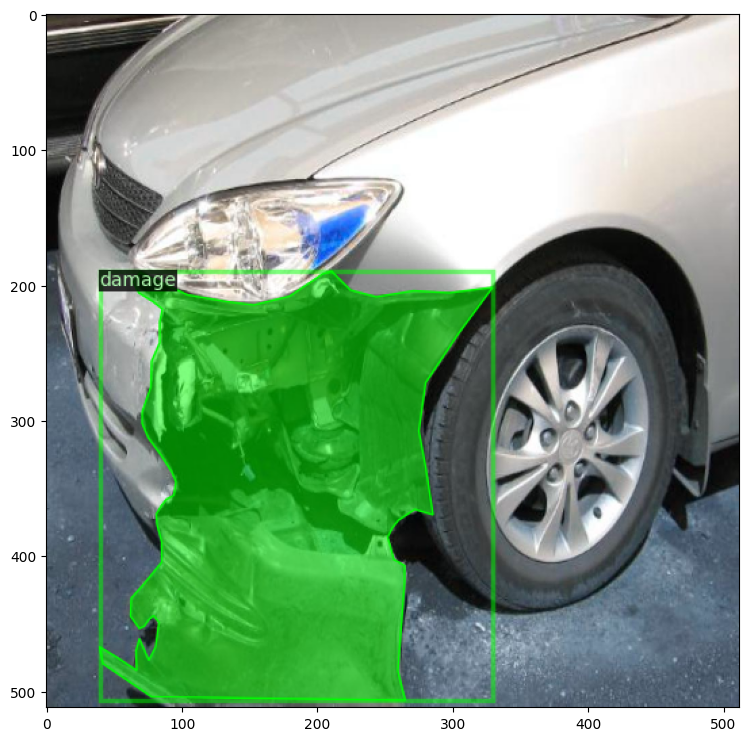

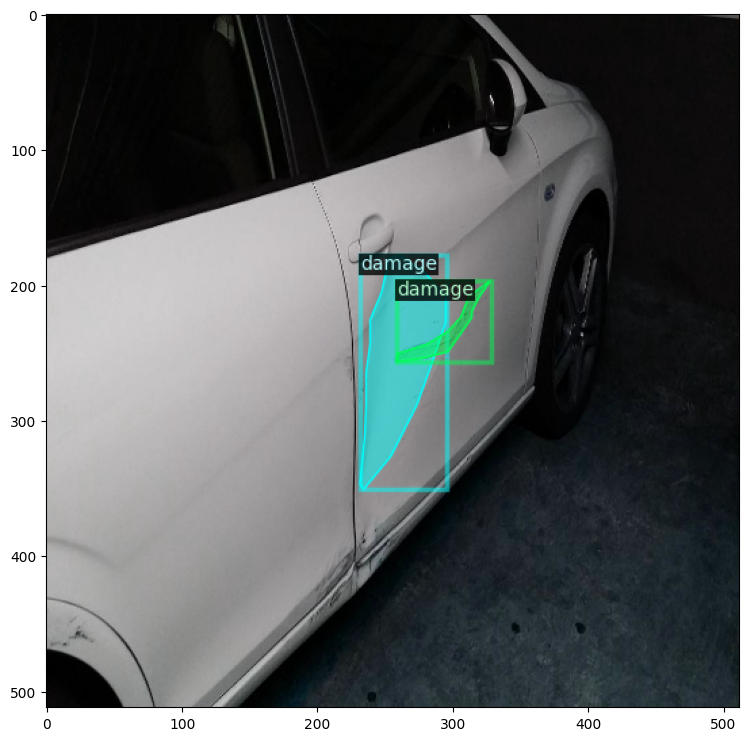

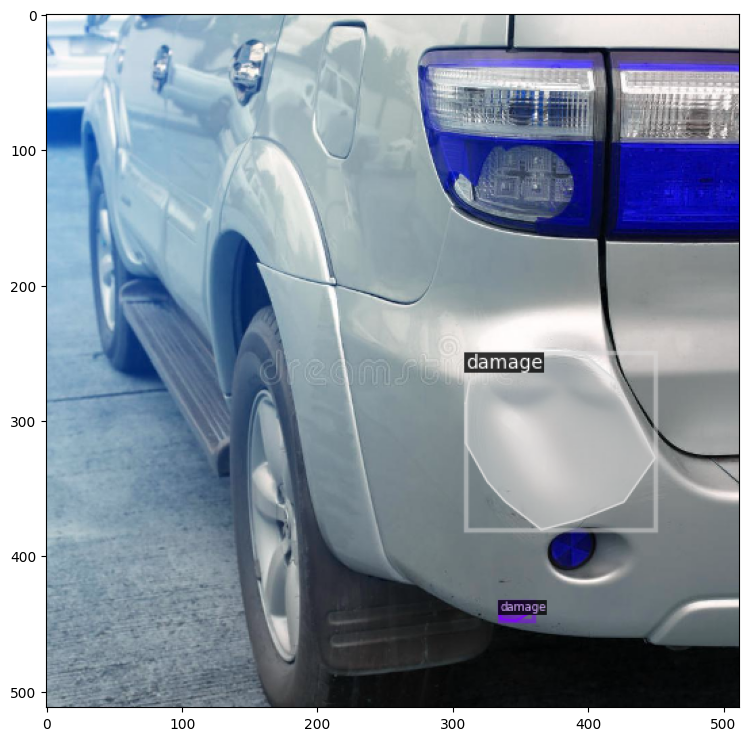

In [14]:
# To verify the dataset is in correct format, let's visualize the annotations of randomly selected samples in the training set:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata_dicts, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    #cv2_imshow(out.get_image()[:, :, ::-1])
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

## Train

In [40]:
cfg.OUTPUT_DIR

'./output/output_20240301_160451'

In [28]:
cfg = get_cfg()
cfg.OUTPUT_DIR = f"./output/output_{datetime.datetime.now().strftime('%Y%m%d_%T').replace(':', '')}"

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("car_dataset_train",)
cfg.DATASETS.TEST = ("car_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 4

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.MODEL.DEVICE='cpu'

cfg.SOLVER.IMS_PER_BATCH = 2  # 2,4    This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300  # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []  # do not decay learning rate

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 8   # images used to calculate cls and reg loss during training. 128 is faster, and good enough for this  dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (damage)


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [29]:
# Add validation metrics to the tensorboard: https://github.com/ravijo/detectron2_tutorial/blob/main/main.py

from tfboard_validation.trainer import Trainer
from tfboard_validation.val_loss_hook import ValLossHook
from detectron2.engine import hooks


trainer = Trainer(cfg)

# creates a hook that after each iter calculates the validation loss on the next batch
# Register the hoooks
trainer.register_hooks([ValLossHook(cfg)])

# The PeriodicWriter needs to be the last hook, otherwise it wont have access to valloss metrics
# Ensure PeriodicWriter is the last called hook
periodic_writer_hook = [hook for hook in trainer._hooks if isinstance(hook, hooks.PeriodicWriter)]
all_other_hooks = [hook for hook in trainer._hooks if not isinstance(hook, hooks.PeriodicWriter)]
trainer._hooks = all_other_hooks + periodic_writer_hook


trainer.resume_or_load(resume=False)
trainer.train()

[03/01 16:04:55 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[03/01 16:04:56 d2.engine.train_loop]: Starting training from iteration 0
[03/01 16:08:01 d2.utils.events]:  eta: 0:24:55  iter: 19  total_loss: 2.378  loss_cls: 0.6813  loss_box_reg: 0.6569  loss_mask: 0.6939  loss_rpn_cls: 0.2029  loss_rpn_loc: 0.01769  val_total_loss: 2.453  val_loss_cls: 0.693  val_loss_box_reg: 0.9719  val_loss_mask: 0.6938  val_loss_rpn_cls: 0.09627  val_loss_rpn_loc: 0.02308    time: 5.1060  last_time: 5.4721  data_time: 0.2706  last_data_time: 0.0010   lr: 1.6068e-05  
[03/01 16:11:21 d2.utils.events]:  eta: 0:23:58  iter: 39  total_loss: 2.507  loss_cls: 0.6499  loss_box_reg: 0.935  loss_mask: 0.6899  loss_rpn_cls: 0.1249  loss_rpn_loc: 0.02141  val_total_loss: 2.241  val_loss_cls: 0.6367  val_loss_box_reg: 0.7658  val_loss_mask: 0.6894  val_loss_rpn_cls: 0.06462  val_loss_rpn_loc: 0.02393    time: 5.5036  last_time: 5.1682  data_time: 0.0016  last_data_time: 0.0012   lr: 3.2718e-05  
[03/01 16:14:27 d2.utils.events]:  eta: 0:22:03  iter: 59  total_loss: 2.245

In [31]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 31680), started 2 days, 17:35:37 ago. (Use '!kill 31680' to kill it.)

# Inference & evaluation using the trained model

#### Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:

In [32]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[03/04 11:24:11 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/output_20240301_160451\model_final.pth ...


#### Then, we randomly select several samples to visualize the prediction results on validation data

In [33]:
dataset_val_dicts = DatasetCatalog.get("car_dataset_val")
metadata_val_dicts = MetadataCatalog.get("car_dataset_val")

[03/04 11:24:38 d2.data.datasets.coco]: Loaded 11 images in COCO format from data/coco/val/COCO_val_annos.json


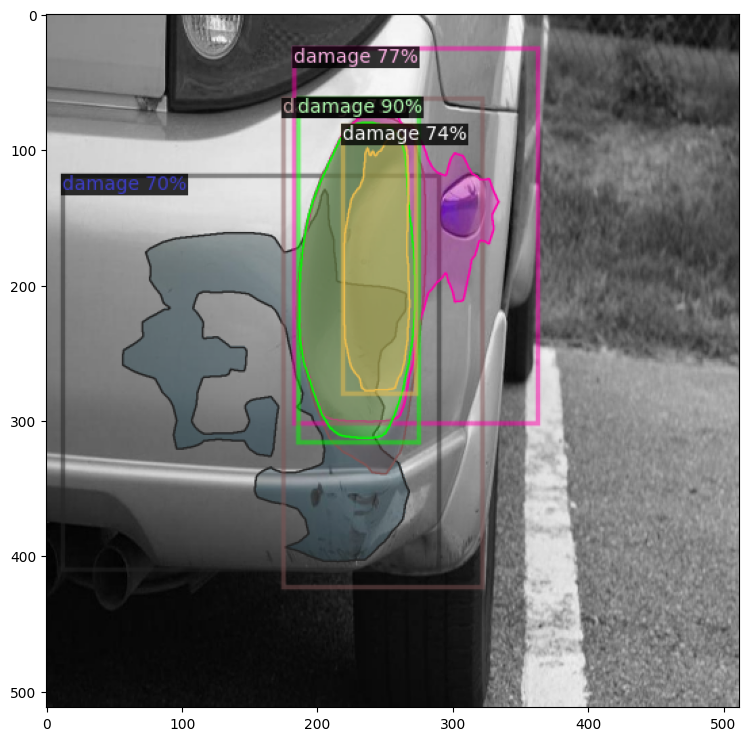

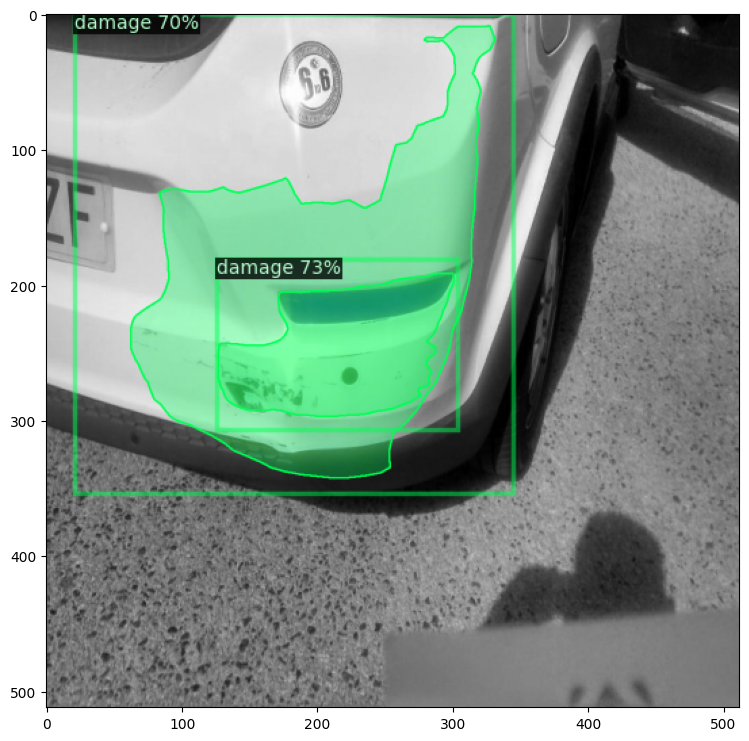

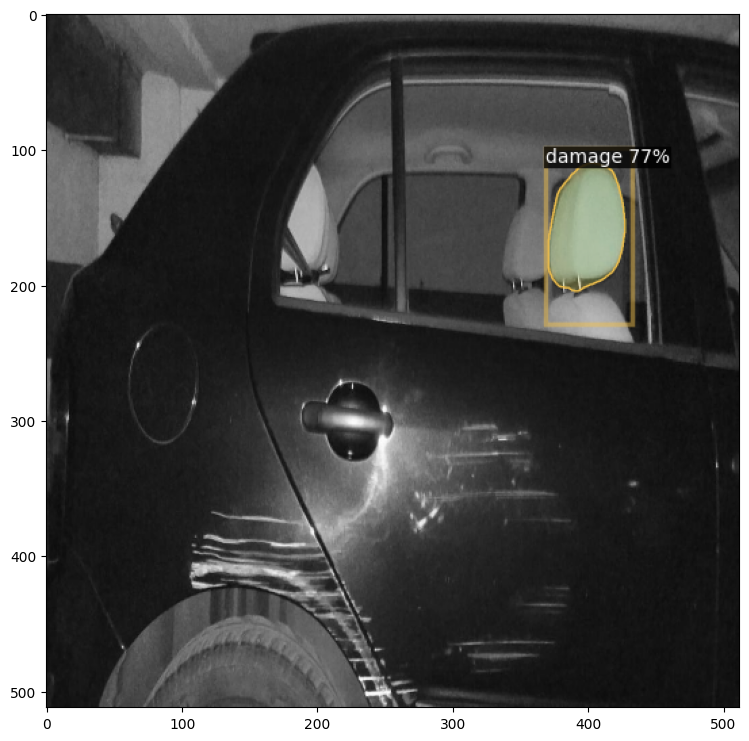

In [34]:
from detectron2.utils.visualizer import ColorMode
#dataset_dicts = get_balloon_dicts("balloon/val")
for d in random.sample(dataset_val_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=metadata_val_dicts, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    #cv2_imshow(out.get_image()[:, :, ::-1])
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

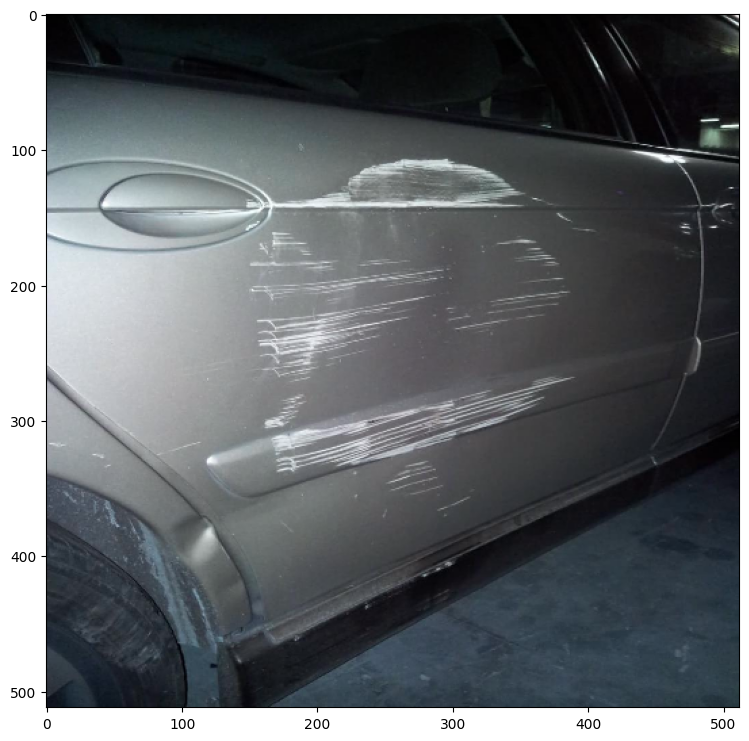

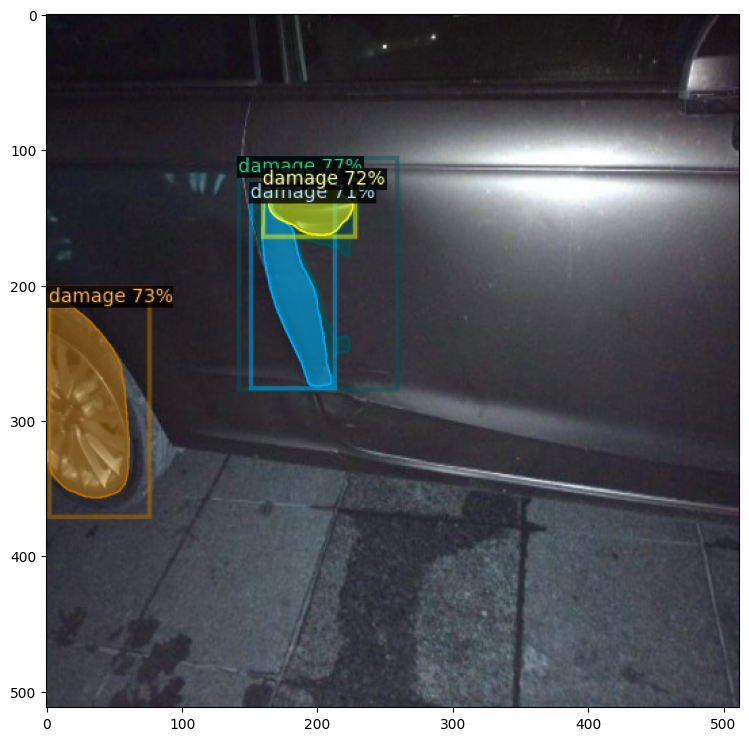

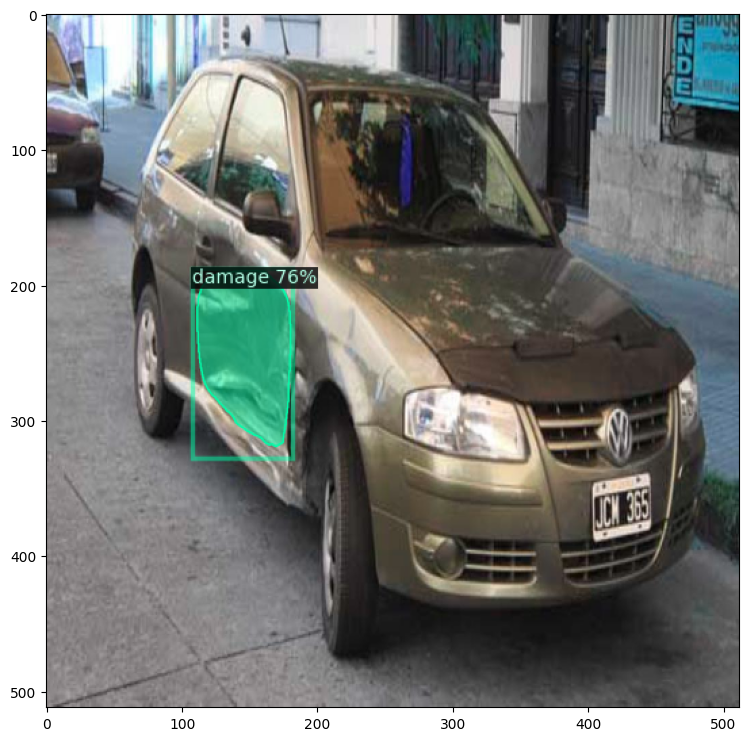

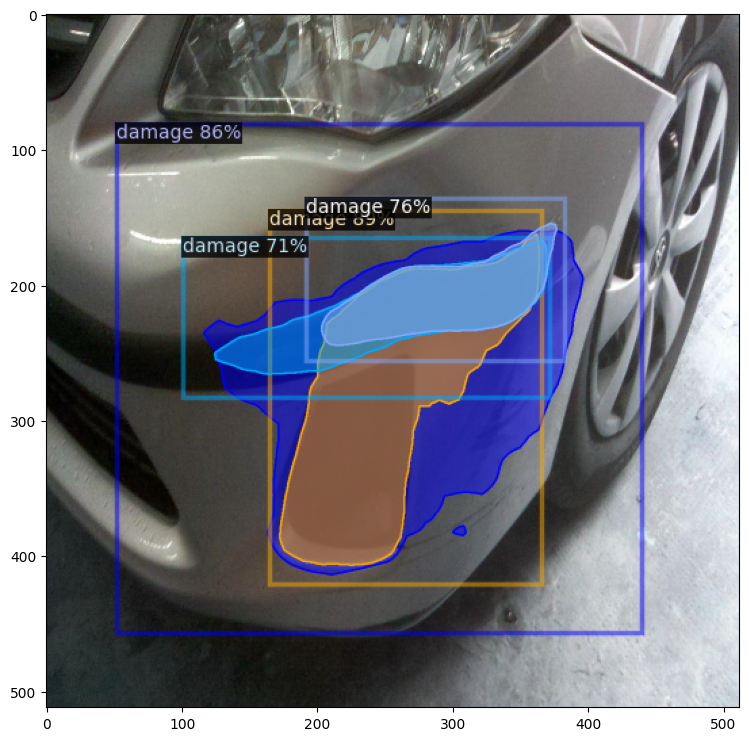

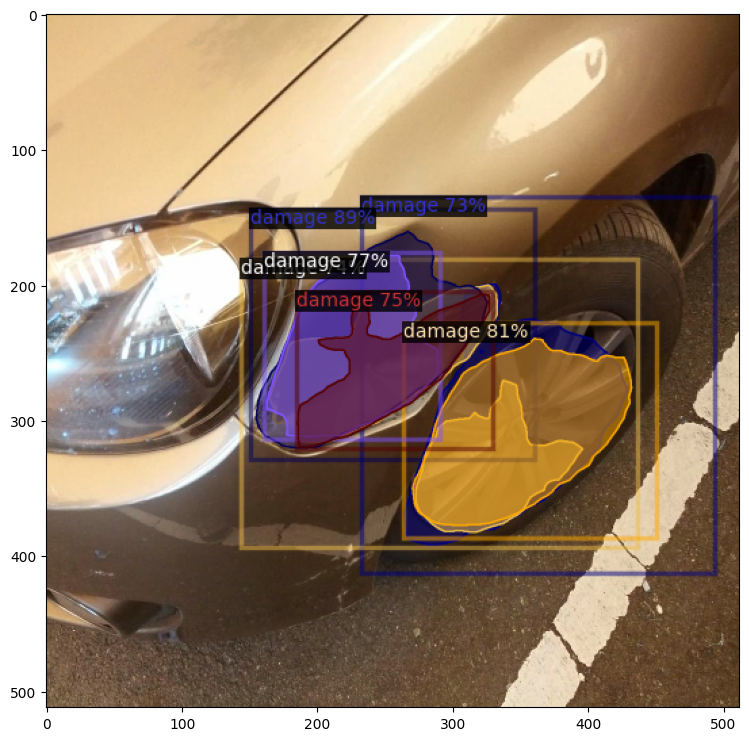

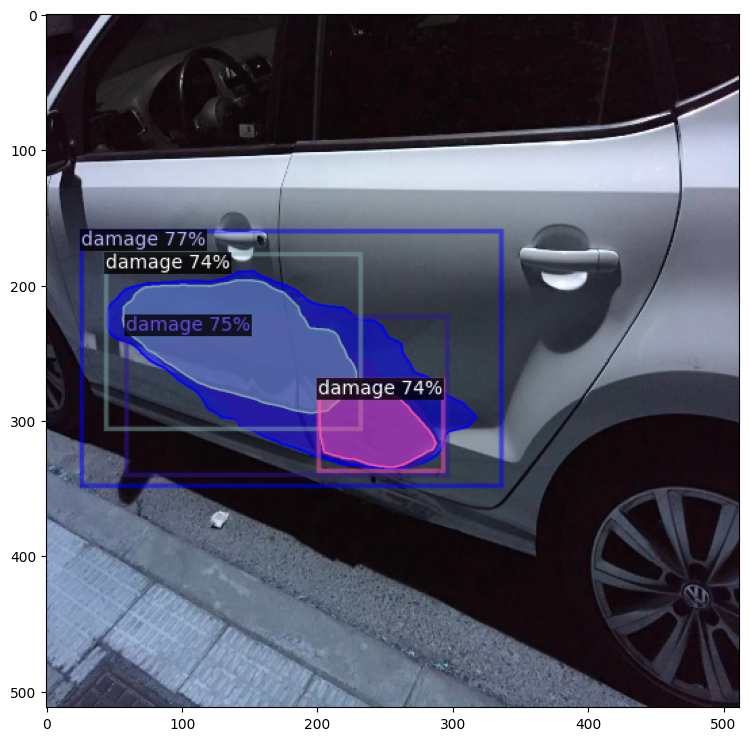

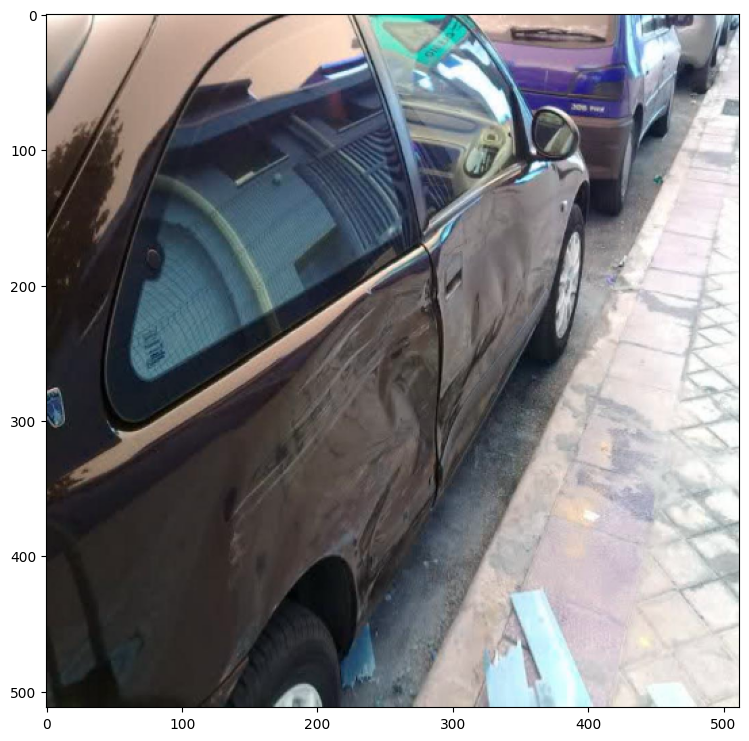

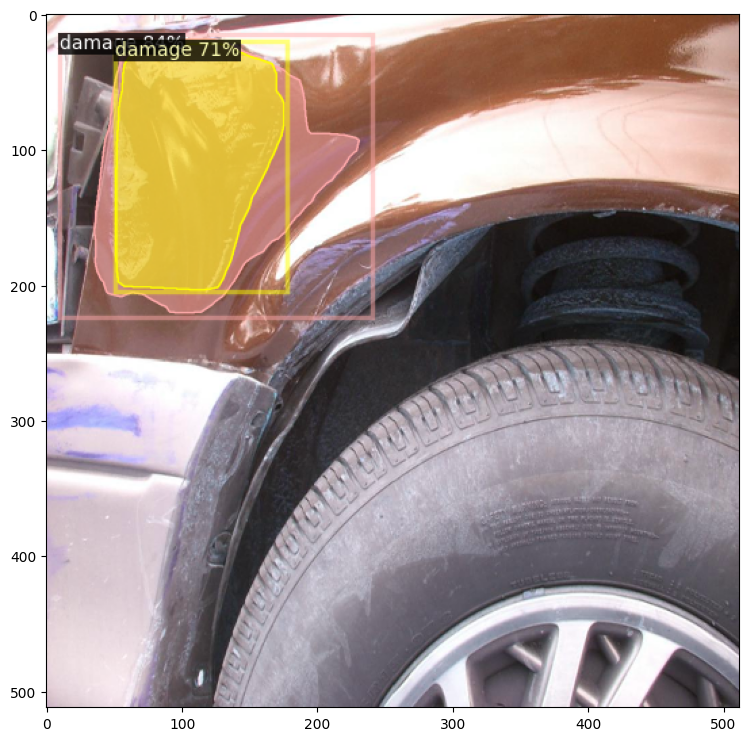

In [36]:
# Check the model on test data

import glob

for img in glob.glob(f'{test_dir}*.jpg'):
  im = cv2.imread(img)
  #print(im)
  output = predictor(im)
  #plt.imshow(im)
  #plt.show()
  #print(output)

  # We can use `Visualizer` to draw the predictions on the test images
  v = Visualizer(im[:, :, ::-1], metadata_dicts, scale=0.5)
  out = v.draw_instance_predictions(output["instances"].to("cpu"))
  #cv2_imshow(out.get_image()[:, :, ::-1])
  plt.imshow(out.get_image()[:, :, ::-1])
  plt.show()

#### We can also evaluate its performance using AP metric implemented in COCO API. This gives an AP of ~5.

In [37]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("car_dataset_val", output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "car_dataset_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[03/04 11:26:03 d2.data.datasets.coco]: Loaded 11 images in COCO format from data/coco/val/COCO_val_annos.json
[03/04 11:26:03 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/04 11:26:03 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[03/04 11:26:03 d2.data.common]: Serializing 11 elements to byte tensors and concatenating them all ...
[03/04 11:26:03 d2.data.common]: Serialized dataset takes 0.01 MiB
[03/04 11:26:03 d2.evaluation.evaluator]: Start inference on 11 batches
[03/04 11:26:30 d2.evaluation.evaluator]: Inference done 11/11. Dataloading: 0.0004 s/iter. Inference: 2.0060 s/iter. Eval: 0.0078 s/iter. Total: 2.0142 s/iter. ETA=0:00:00
[03/04 11:26:30 d2.evaluation.evaluator]: Total inference time: 0:00:12.349996 (2.058333 s / iter per device, on 1 devices)
[03/04 11:26:30 d2.evaluation.evaluator]: Total infe